In [36]:
using NotebookSIAMFANL
using SIAMFANLEquations
using LinearAlgebra
using SIAMFANLEquations.TestProblems
using PyPlot

## Section 1.10 Solvers for Chapter 1

Contents for Section 1.10

[Overview](#Overview)

[nsolsc.jl](#nsolsc.jl)


### Overview

We provide two solvers for this chapter. __nsolsc.jl__ is a scalar Newton code. Its calling sequence and the tuple it returns are very similar to all the codes from this book. All our solvers return a tuple with the solution, the history of the iteration, flags for success or failure, and (optionally) the entire history of the solution. 

The solution hisory for scalar equations is small and returning it is the default. In the later chapters on systems of equations, we do not return the solution history by default and discourage your asking for it. The solution history might take a lot of space to store and also, especially in Julia, have a severe penalty for allocations.

### nsolsc.jl

__nsolsc.jl__ is the scalar Newton solver. We will begin, as we will in all the software sections, by looking at the documentation in the code.

In [2]:
? nsolsc

search: nsolsc



nsolsc(f,x, fp=difffp; rtol=1.e-6, atol=1.e-12, maxit=10,         solver="newton", sham=1, armmax=10, resdec=.1,         armfix=false, printerr=true, keepsolhist=true)

Newton's method for scalar equations. Has most of the features a code for systems of equations needs.

Input:

f: function

x: initial iterate

fp: derivative. If your derivative function is fp, you give me its name. For example fp=foobar tells me that foobar is your function for the derivative. The default is a forward difference Jacobian that I provide.

Options:

rtol, atol: real and absolute error tolerances

maxit: upper bound on number of nonlinear iterations

solver:

Your choices are "newton"(default), "secant", or "chord". However,  you have sham at your disposal only if you chose newton. "chord" will keep using the initial derivative until the iterate converges, uses the iteration budget, or the line search fails. It is not the same as sham=Inf, which is smarter.

If you use secant and your initial iterate is poor, you have made a mistake. I will help you by driving the line search with a finite difference derivative.

sham:

This is the Shamanskii method. If sham=1, you have Newton. The iteration updates the derivative every sham iterations. The covergence rate has local q-order sham+1 if you only count iteratons where you update the derivative. You need not provide your own derivative function to use this option. sham=Inf is chord only if chord is converging well.

armmax: upper bound on stepsize reductions in linesearch

resdec: target value for residual reduction. 

The default value is .1. In the old MATLAB codes it was .5. I only turn Shamanskii on if the residuals are decreasing rapidly, at least a factor of resdec, and the line search is quiescent. If you want to eliminate resdec from the method ( you don't ) then set resdec = 1.0 and you will never hear from it again.  

armfix:

The default is a parabolic line search (ie false). Set to true and the stepsize will be fixed at .5. Don't do this unless you are doing experiments for research.

printerr:

I print a helpful message when the solver fails. To supress that message set printerr to false.

keepsolhist:

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

Output:

A tuple (solution, functionval, history, stats, idid, solhist) where history is the vector of residual norms (|f(x)|) for the iteration and stats is a tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian evaluation. I do count them for the secant method model.

idid=true if the iteration succeeded and false if not.

solhist:

This is the entire history of the iteration if you've set keepsolhist=true


#### Input


Let's begin with the calling sequence for the solver.

```julia
nsolsc(
    f,
    x,
    fp = difffp;
    rtol = 1.e-6,
    atol = 1.e-12,
    maxit = 10,
    solver = "newton",
    sham = 1,
    armmax = 5,
    resdec = .1,
    armfix = false,
    keepsolhist = true,
)
```

The arguments before the semicolon are required. We are solving $f(x) = 0$ and the solver needs $f$ and the initial iterate $x$. The arguments after the semicolon are __keyword arguments__, usually refered to as __kwargs__, which is not a German cheese product. The semicolon is __very important__. Do not leave it out when using kwargs. The
good news about kwargs is that you may use any of them without worrying about the others, which will take their default values. So

```julia
nsolout0 = nsolsc(atan, 1.0)

nsolout1 = nsolsc(atan, 1.0; solver = secant)

nsolout2=nsolsc(atan, 3.0; sham=2, resdec=.5)
```
are all correct.


You have seen many of the kwargs before. The realtive and absolute error tolerances, the solver, the parameters
for the Shamanskii method and line search should be familiar. The new things are __resedec__, __armfix__, and __keepsolshist__. For example, the derivative is updated every __sham__ iterations. Newton's method is sham=1.

The default for derivative evaluation is a forward difference derivative. That is an internal function __difffp__.
If you have an analytic derivative, say __fpanal.jl__, then set fp=fpanal and the solver will use your derivative.

The documentation explains these parameters. We have mentioned the solution history before. Pleaes leave __keepsolhist__ alone unless there's a good reason to change it. It is set to true for scalar codes and false for
the solvers in the following chapters.

__resdec__ is how we manage Shamanskii iterations. In this scalar code, it is used for some examples and to prepare you for its more serious use in the codes for systems of equations. In __nsolsc.jl__ the default solver is Newton's method (so sham=1). Newton with sham=2 is the Shamanskii method with a derivative update every two iterations. 
__But__ we safeguard the skipping of the update by doing the update anyhow if (1) the line search fails on the first attempt (ie with step length = 1) or (2) the residual decrease is more than __resdec__. If you want to eliminate the second of these, set resdec = 1. The only exception to the first criterion is the chord method. If you set solver='chord' then you will get chord. That's in there for research and a few internal tests of the code. 
If you set sham=Inf, then you'll get the chord method with derivative updates when a step length of 1 fails to produce sufficient decrease or the reduction in residuals is not enough.

We also compute a difference derivative in the secant method if the line search kicks in. As I said in the comment lines near that part of the code ...

```Julia
#=
     If you like the secant or sham=large methods, I will do a 
     difference Jacobian anyhow if the line search kicks in. 
     You will thank me for this.
     Even if you don't thank me, I will do it anyhow.
    
      If you insist, solver=chord will ignore poor convergence and let
     things go south with no interference. Please don't do that as
     standard procedure.
=#
```



#### Output

The output of all the solvers is a tuple. This is a data structure in Julia that can pack differnet structures (including more tuples) in one thing. It's a good way to manage complex output.

Here is a simple example of how to use the output tuple. I'll find the root of $f(x) = tan^{-1}(x)$ and look at the iteration statistics.

In [3]:
tanout=nsolsc(atan,10.0)

(solution = -1.13371e-06, functionval = -1.13371e-06, history = [1.47113e+00, 1.19982e+00, 1.10593e+00, 6.48294e-01, 2.56979e-01, 1.19356e-02, 1.13371e-06], stats = (ifun = [1, 3, 2, 2, 1, 1, 1], ijac = [0, 1, 1, 1, 1, 1, 1], iarm = [0, 2, 1, 1, 0, 0, 0]), idid = true, solhist = [1.00000e+01, 2.57080e+00, -1.99394e+00, 7.57517e-01, -2.62790e-01, 1.19362e-02, -1.13371e-06])

As the problems become larger in the course of the book. I will start putting a semicolon after calls to the solvers. I've taken the defaults for everything, so the iteration terminated when the residual was about $10^{-6}$. Note that the solution history is part of the output. You can (and should) turn this off for systems of equations where the solution history can become a massive storage burden. It may be useful if you want to visualize the history with a movie, but is rarely worth the trouble. The solution and final function values are ...

In [5]:
[tanout.solution tanout.functionval]

1×2 Array{Float64,2}:
 -1.13371e-06  -1.13371e-06

Looking at the itereation history can help you find errors or convince you that things are going well. One simple thing we will do often is to plot a semilog graph of the residual history. If we are comparing methods, it is a good idea to plot $|f(x_n)|/|f(x_0)|$ to that all the plots will begin at the same point. Here is a simple version of that. I like to label things, so I did that too. Since I'll be publishing this as a print book, I'll make the curves black to save on publication costs.

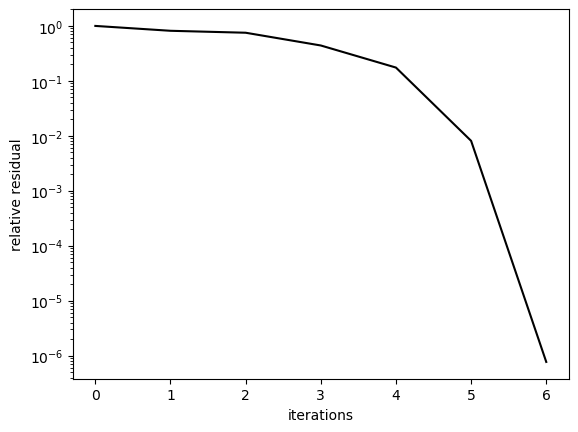

PyObject Text(24.000000000000007, 0.5, 'relative residual')

In [21]:
residdata=tanout.history./tanout.history[1]; sizehist=length(residdata)
semilogy(0:sizehist-1,residdata,"k-")
xlabel("iterations")
ylabel("relative residual")

PyPlot is very similar to Matlab, which is why I use it. The stats array has the data for function and derivative evaluations and the number of stepsize reductions in the line search. As you can see, the line search had some work to do in this example. If the iteration is not doing what you expect, a quick look at stats may help.

In [13]:
tanout.stats

(ifun = [1, 3, 2, 2, 1, 1, 1], ijac = [0, 1, 1, 1, 1, 1, 1], iarm = [0, 2, 1, 1, 0, 0, 0])

Here we see thatthe line search was active on iterations 1, 2, and 3 and every step size reduction costs a function evaluation like it's supposed to.

Now we can play with the options. Lets tighten the tolerances and compare three solvers.

In [26]:
tannewt=nsolsc(atan,1.0; rtol=1.e-12, atol=1.e-12);
tansec=nsolsc(atan,1.0; rtol=1.e-12, atol=1.e-12, solver="secant");
tanchord=nsolsc(atan,1.0; rtol=1.e-12, atol=1.e-12, solver="chord");

Newton failure; maybe increase maxit and/or armmax
Current values: maxit  =  10, armmax = 5
Give the history array a look to see what's happening.
  


Look! The chord method failed to converge. Let's see what happened

In [27]:
tanchord.history

11-element Array{Float64,1}:
 7.85398e-01
 5.18669e-01
 4.36525e-01
 3.86104e-01
 3.50593e-01
 3.23686e-01
 3.02326e-01
 2.84806e-01
 2.70083e-01
 2.57474e-01
 2.46512e-01

Yes, that's going nowhere at all. The problem is that the derivative at $x_0 = 1$ is not good enought to make the chord iteration convcerge well. It would get there eventually, but only after far more iterations that you or I have the patience for. Let's plot the results and see what we got

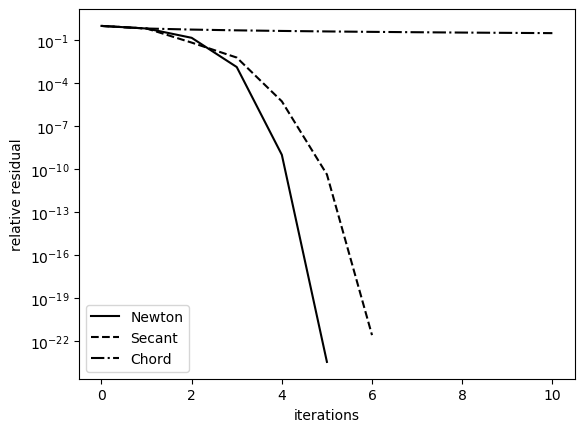

PyObject Text(24.000000000000007, 0.5, 'relative residual')

In [34]:
residdatan=tannewt.history./tannewt.history[1]; sizehistn=length(residdatan)
residdatas=tansec.history./tansec.history[1]; sizehists=length(residdatas)
residdatac=tanchord.history./tanchord.history[1]; sizehistc=length(residdatac)
semilogy(0:sizehistn-1,residdatan,"k-",
0:sizehists-1,residdatas,"k--",
0:sizehistc-1,residdatac,"k-."
)
legend(["Newton","Secant","Chord"])
xlabel("iterations")
ylabel("relative residual")

This is exactly what you'd expect. The histories for the secant and Newton iterations have the downward concavity of superlinear convergence. Newton's method takes fewer nonlinear iterations (but only by one) while the secant method uses fewer calls to functions. Remember that Newton does a function and derivative evaluation at each step, while the secant iteration only needs a single function evaluation per step. 

We've seen how to run the solver, pick methods, and look at the output. We are almost done with this section and ready to move on to systems of equations in [Chapter 2](SIAMFANLCh2.ipynb). The last thing to do is talk about how to package your function. Suppose you have Julia code for your function (__myfun.jl__) and its derivative (__myfunp.jl__). Once in the REPL or a notebook, you can put these functions where Julia can find then with the __include__ command. You'd do

```Julia
include("myfun.jl")
include("myfunp.jl")
```
and then could invoke the solvers. This is far from idea for many reasons.

Julia is a complied language. The code for your functions is complied when you invoke the __include__ command. If you make a change to __myfun.jl__, you would have to include it again before you could use it. 

A better way is to use a module to contain all the code you need for your function. __MyFunction.jl__ is an
example of such a module

```Julia
module MyFunction

export(myfun)
export(myfunp)

function myfun(x)
    fun=cos(x)-x
    return fun
end

function myfunp(x)
    funp=-sin(x)-1
    return funp
end
end
```

I've put __MyFunction.jl__ in the src/Chapter1 directory of NotebookSIAMFANL and made it a submodule of NotebookSIAMFANL. To start using it invode the __using__ command. 


In [38]:
using NotebookSIAMFANL.MyFunction

To see if the functions are where they need to be, we'll evaluate them.

In [41]:
x=pi;
y=myfun(x);
yp=myfunp(x);
[y,yp]

2-element Array{Float64,1}:
 -4.14159e+00
 -1.00000e+00

We now have both __myfun__ and its derivative __myfunp__ ready to go. We will compare Newton's method with an analytic derivative to the iteration with a forward difference derivative (the default).

In [45]:
myfunforwarddiff=nsolsc(myfun,1.0);
myfunanalytic=nsolsc(myfun,1.0,myfunp);
myfunforwarddiff.history-myfunanalytic.history

4-element Array{Float64,1}:
 0.00000e+00
 6.53120e-09
 4.36679e-10
 1.00131e-12

There's no significant difference. We will return to this in the subsequent chapters.

### ptcsolsc.jl

This is the scalar pseudo-transient continuation solver. As usual, we will start with the docstrings

In [46]:
?ptcsolsc

search: ptcsolsc



ptcsolsc(f, x, fp=difffp; rtol=1.e-6, atol=1.e-12, fp=difffp,          dt0=1.e-6, maxit=100, keepsolhist=true)

Scalar pseudo-transient continuation solver. PTC is designed to find stable steady state solutions of 

dx/dt = - f(x)

It is ABSOLUTELY NOT a general purpose nonlinear solver.

Input:

f: function

x: initial iterate/data

fp: derivative. If your derivative function is fp, you give me its name. For example fp=foobar tells me that foobar is your function for the derivative. The default is a forward difference Jacobian that I provide.

Options:

rtol, atol: real and absolute error tolerances

dt0: initial time step. The default value of 1.e-3 is a bit conservative  and is one option you really should play with. Look at the example where I set it to 1.0!

maxit: upper bound on number of nonlinear iterations. This is  coupled to dt0. If your choice of dt0 is too small (conservative) then you'll need many iterations to converge and will need a larger value of maxit.

keepsolhist: if true you get the history of the iteration in the output  tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

Output: A tuple (solution, functionval, history, idid, solhist) where history is the array of absolute function values |f(x)| of residual norms and time steps. Unless something has gone badly wrong, dt approx |f(x_0)|/|f(x)|.

idid=true if the iteration succeeded and false if not.

solhist=entire history of the iteration if keepsolhist=true

If the iteration fails it's time to play with the tolerances, dt0, and maxit. You are certian to fail if there is no stable solution to the equation.
